In [1]:
import numpy as np
import tensorflow as tf

import argparse
import time
import os

from model import *
from importlib import reload
from dataloader import DataProcess
from sample import *
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

Saved {} lines 949
Number of data examples: 901
Batch size for dataset 300
['Mr. Macmillan wound up the two-day', 'have to be accompanied by other', 'underdeveloped countries alike."']


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
def init_args():
    
        args = {}
        args['rnn_size'] = 100 
        args['tsteps'] = 300 
        args['batch_size'] = 32 
        args['num_batches'] = 500 
        args['num_mixtures'] = 20 # number of MDN mixtures
        args['window_mixtures'] = 10 # number of attention window mixtures
        args['learning_rate'] = 0.001
        args['epochs'] = 2500 
        args['alphabet'] = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        args['tsteps_per_char'] = 25
        
        args['biases'] = 1.0
        args['data_dir'] = "./data"
        args['logs_dir'] = './logs/'
        args['save_path'] = 'modelwindow/model.ckpt' # path to save the model at
        args['load_path'] = 'modelwindow/model.ckpt' # path to load the model from
        args['grad_clip'] = 10
        args['n_to_save'] = 500 #step difference at which to save the model
        args['scale_factor'] = 20
        args['gap'] = 500 #remove data with gap greater than this threshhold
        args['learning_rate_decay'] = 0.99 
        args['keep_prob'] = 0.85 # keep_prob for dropout
        args['train'] = False
        args['decay'] = 0.95
        args['momentum'] = 0.9
        return args

def load_pretrained_model(model, path):
        global_step = 0
        try:
            save_dir = '/'.join(path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            model.saver.restore(model.sess, load_path)
            #load_was_success = True
        except Exception as e:
            print(e)
            load_was_success = False
        else:
            model.saver = tf.train.Saver(tf.global_variables())
            global_step = int(load_path.split('-')[-1])
            load_was_success = True
        return load_was_success, global_step
    
def train_model():
    args = init_args()
    args['train'] = True
    data_loader = DataProcess(args)
    
    # num_batches is calculated in dataloader based on total data size and batch_size
    args['num_batches'] = data_loader.num_batches
    print("num_bacthes", args['num_batches'])
    
    model = Model(args)
    #global_step = 0
    load_was_success, global_step = load_pretrained_model(model, args['save_path'])
    
    # list to hold the loss values in each itration of the mini batch
    plot_loss = []
    model.sess.run(tf.assign(model.decay, args['decay']))
    model.sess.run(tf.assign(model.momentum, args['momentum']))
    
    # Mini batch for given number of epochs
    for e in range(int(global_step/args['num_batches']), args['epochs']):
        print("Running epoch", e)
        
        # learning rate decay
        model.sess.run(tf.assign(model.learning_rate, args['learning_rate'] * (args['learning_rate_decay'] ** e)))
        
       
        # initializes data pointer to starting of batch in each epoch
        data_loader.init_batch_comp()
        c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
        h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
        kappa = np.zeros((args['batch_size'], args['window_mixtures'], 1))

        for b in range(global_step%args['num_batches'], args['num_batches']):

            i = e * args['num_batches'] + b
            if global_step is not 0 : i+=1 ; global_step = 0

            if i % args['n_to_save'] == 0 and (i > 0):
                # save the model we have right now
                model.saver.save(model.sess, args['save_path'], global_step = i) ;
            
            # get next batch of data to train on
            x, y, asciis, asciis_oh = data_loader.get_next_batch()
            
            feed = {model.input: x, model.output: y, model.char_seq: asciis_oh, model.kappa_start: kappa, \
                    model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                    model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
            [train_loss, _] = model.sess.run([model.cost, model.train_op], feed)

            plot_loss.append(train_loss)
        print("train_loss: " + str(i))
        print(train_loss)
    
    # plotting the loss graph
    plt.plot(plot_loss, linewidth=2.0)
    plt.savefig("./loss.png")

# Function to sample some handwriting, this does not try to sample any particular style YET
def sample_model():
    args = init_args()
    args['train'] = 0
    # args['batch_size'] = 1

    model = Model(args)
    
    # load a pretrained model
    s = "Hello Welcome to our project"
    load_was_success, global_step = load_pretrained_model(model, args['load_path'])
    if load_was_success:
            strokes, char_to_plot, phis, windows, kappas = sample(s, model, args)
            line_plot_coef(strokes, 'Line plot', figsize = (20,4), save_path="./coef_plot7.png")
            line_plot_char(strokes, char_to_plot, 'Line plot', figsize = (20,4), save_path="./line_char7.png")
            print("plotted")

    else:
        print("Model failed to load, can't sample")


            
            
            
            
            
            
            
            
            
    

100 30
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from modelwindow/model.ckpt-1000


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/home/ubuntu/Notebooks/CS230-handwriting-synthesis/sample.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  x = np.random.multivariate_normal(mean, cov, 1)


[2.232664, 0.45382214, 0.7592108, 0.8456702, -0.0026327386, 0.07793211]
New point: 1.6025057934845024 -1.6336128526421998 1
[0.06918184, -0.100342356, 0.16900638, 0.24139793, -0.35844606, 0.028441157]
New point: -0.2527334431403434 -0.22361670245875676 1
[-0.41025034, -0.18688813, 0.16088863, 0.20844398, -0.20339638, 0.013782468]
New point: -0.5470216787984419 -0.19585960789531587 0
[-0.4464265, -0.028610345, 0.088127024, 0.12515931, -0.12650092, 0.010640807]
New point: -0.4701347610841921 0.06985166703746912 0
[-0.6391188, -0.2463128, 0.06369884, 0.111469366, 0.13769856, 0.017814767]
New point: -0.6549981612120557 -0.25844412821204654 0
[-0.826255, -0.29971772, 0.044179372, 0.08493292, 0.37550128, 0.012940319]
New point: -0.7940958577184535 -0.35904946160693957 0
[-0.94386214, 0.12133099, 0.046933454, 0.08606106, 0.28381187, 0.0065751756]
New point: -0.8945067199544221 0.15257901973903362 0
[-0.93140054, 0.39591476, 0.05134888, 0.090285234, 0.18528761, 0.00405102]
New point: -0.954816

[-0.31156608, 0.82842934, 0.057516396, 0.07824221, 0.22008388, 0.009585105]
New point: -0.33536290738779323 0.767263939207589 0
[-0.25126418, 0.7025985, 0.05282028, 0.073563166, 0.251445, 0.018424595]
New point: -0.2550871140480015 0.6493509309358273 0
[-0.092000395, 0.44024572, 0.047192976, 0.06665589, 0.3268171, 0.039933257]
New point: -0.08335181689598818 0.42820116493886823 1
[2.8076527, -5.4115677, 0.6592044, 0.87648696, 0.0606495, 0.004927652]
New point: 2.99989943836573 -5.2607672925515185 0
[0.20683235, 0.032675844, 0.12699653, 0.17190315, -0.4346101, 0.024188006]
New point: 0.48086332458336 -0.020394165104715187 1
[8.454632, -1.3235986, 2.3676255, 1.6193004, -0.15800701, 0.013618389]
New point: 8.640607352375635 -1.1097965817333952 0
[-0.0072709247, -0.0017640367, 0.01581833, 0.011024696, -0.58820987, 0.0054006903]
New point: -0.006909752295235174 0.001545904196452699 0
[-0.07020149, -0.0063732024, 0.03173587, 0.027597036, 0.44176626, 0.006530244]
New point: -0.136255810524241

[7.9339747, -0.79109126, 2.6105015, 1.6271071, -0.341453, 0.013064468]
New point: 8.925338100353038 -3.5557758034667573 0
[-0.02839405, -0.07943315, 0.17825998, 0.141385, -0.6486608, 0.008280956]
New point: -0.12718844929136935 0.04103254212666517 0
[-0.34061387, 0.43122655, 0.09655641, 0.086534224, 0.26885167, 0.00671172]
New point: -0.35626192100681914 0.41135502358507253 0
[-0.558719, 0.993882, 0.09095288, 0.08614652, 0.13224967, 0.0039151977]
New point: -0.31843023469759735 0.9735343629201821 0
[-0.4490439, 1.2462945, 0.08212164, 0.08136954, 0.169122, 0.0055669015]
New point: -0.5199176395379507 1.3929054740112272 0
[-0.54906297, 1.6231453, 0.08180722, 0.08610297, 0.11448065, 0.0064816647]
New point: -0.5062109876034506 1.5813276453994987 0
[-0.43283942, 1.4304357, 0.076805085, 0.081824556, 0.14232562, 0.013668716]
New point: -0.43702030186988866 1.4512502463972232 0
[-0.24360803, 1.033809, 0.07070982, 0.07511184, 0.23880932, 0.03063597]
New point: -0.2184066881457904 0.98097312416

[5.6065235, -2.050023, 0.81876975, 0.96289796, -0.11625903, 0.0028796047]
New point: 6.276917359612071 -2.5165007335891905 0
[0.09872793, 0.49445397, 0.15030849, 0.24447583, -0.21922784, 0.022307474]
New point: -0.02592009655163305 0.21231434452380749 1
[1.554317, 1.8669175, 0.740604, 0.7027437, -0.29867053, 0.0071904757]
New point: 1.9739929308059265 1.6120138604030854 0


/home/ubuntu/Notebooks/CS230-handwriting-synthesis/sample.py:99: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs

plotted


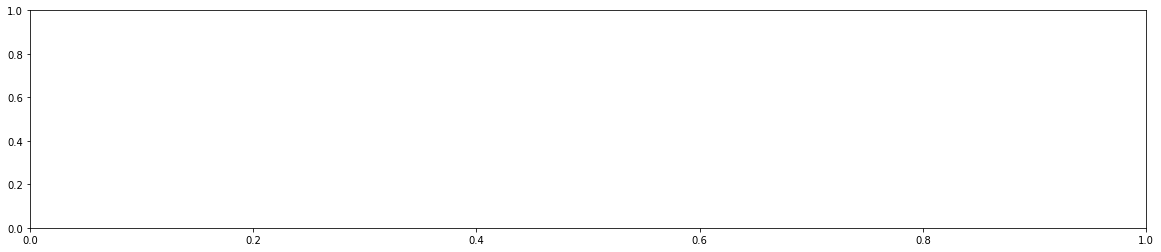

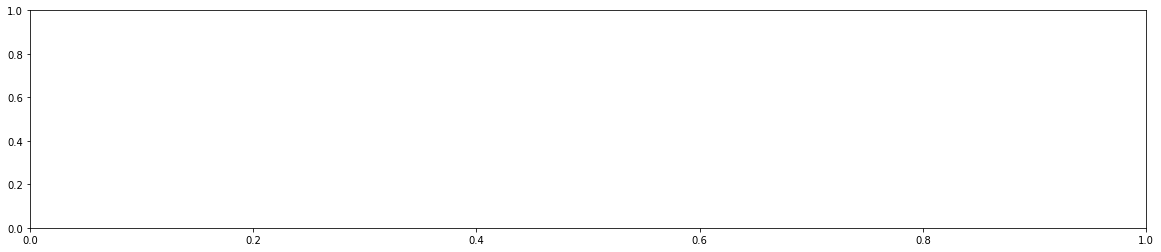

In [3]:
sample_model()